In [1]:
# EMC2 WP 2 Processing 1.1 (MAIN) - Two filters on buildings
# This script performs a series of spatial data processing tasks aimed at preparing building data for further analysis. Firstly, it 
# conducts a spatial join between building and activity area datasets, assigning each building a category of activity area based on spatial 
# intersection. Next, it identifies and removes specific indexes from the building dataset to refine the data for the learning phase of the 
# classification model (1.2). These include light buildings, buildings under construction, annex buildings, and buildings with small footprints. 
# Subsequently, additional indexes are identified and removed from the dataset for the estimation of the number of dwellings (1.3). This includes
# buildings with no dwellings, specialized buildings, and large buildings within specialized areas with null values of dwellings.
# Author : Perez Joan

# Generic input data : building with height values and morphological indicators. activity and administrative areas.
# emc2 input data : output 0.1 (activity and administrative areas) and 1.0 (building with morphological indicators) (MAIN)

# 0.1 Packages, local filepaths & parameters
import geopandas as gpd
from shutil import copy

# Specify the location of output from 1.0
gpkg = "C:\\Users\\jperez\\Documents\\Current 1\\emc2\\Output\\WP2_DPC_06_1.0.gpkg"

# Specify the location of output from 0.1
gpkg_2 = "C:\\Users\\jperez\\Documents\\Current 1\\emc2\\Output\\WP2_DPC_06_0.1.gpkg"

# Specify the file path to record the results
gpkg_save = "C:\\Users\\jperez\\Documents\\Current 1\\emc2\\Output\\WP2_DPC_06_1.1.gpkg"

# Read the data
building = gpd.read_file(gpkg, layer="Buildings_with_morphology_indicators")
activity_area = gpd.read_file(gpkg_2, layer="activity_area")
administrative = gpd.read_file(gpkg_2, layer="administrative")

In [2]:
# 1. Spatial join of categories of activity areas to buildings

building = building.rename(columns={'index_right': 'index_rgt'})
activity_area = activity_area.rename(columns={'index_right': 'index_rgt'})
building = gpd.sjoin(building, activity_area[['categorie', 'geometry']], how='left', predicate='intersects')                                

In [3]:
# 2. Indexes to remove for the learning phase of the classification model

# light buildings
indexes_1 = building[(building["construction_legere"] == True) & (building["nombre_de_logements"].isnull())].index
# Building under construction (not in service)
indexes_2 = building[building["etat_de_l_objet"] != "En service"].index
# Annex buildings (official definition : Petit bâtiment à vocation d'annexe au sens fiscal : garage externe, abri...)
indexes_3 = building[(building["usage_1"] == "Annexe") & (building["nombre_de_logements"].isnull())].index
# Buildings with less the 10 m² of footprint 
indexes_4 = building[building.geometry.area < 10].index

# Removed indexes for the model
merged_idx_1 = indexes_1.union(indexes_2).union(indexes_3).union(indexes_4)
filtered_building_1 = building.drop(merged_idx_1)

In [4]:
# 3. Additional indexes to remove for the regression model

# Building with no dwelling
indexes_5 = building[building["nombre_de_logements"] == 0].index
# Specialized buildings
indexes_6 = building[(building["nature"] != "Indifférenciée") & (building["nombre_de_logements"].isnull())].index
# Large buildings within specialized areas with NULL values of dwellings
indexes_7 = building[(building.geometry.area > 150) & (building["nombre_de_logements"].isnull()) & (~building["categorie"].isnull())].index

# All indexes removed indexes for estimation (section 1.4)
merged_idx_2 = indexes_1.union(indexes_2).union(indexes_3).union(indexes_4).union(indexes_5).union(indexes_6).union(indexes_7)
filtered_building_2 = building.drop(merged_idx_2)

In [5]:
# 5. Write both layers "Buildings_with_dwellings_filtered_0_included" & "Buildings_with_dwellings_filtered_0_excluded"

filtered_building_1.to_file(gpkg_save, layer="Buildings_with_dwellings_filtered_0_included", driver="GPKG")
filtered_building_2.to_file(gpkg_save, layer="Buildings_with_dwellings_filtered_0_excluded", driver="GPKG")

In [6]:
# Appendices
import contextily
import folium
from folium.plugins import MarkerCluster
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import matplotlib.pyplot as plt

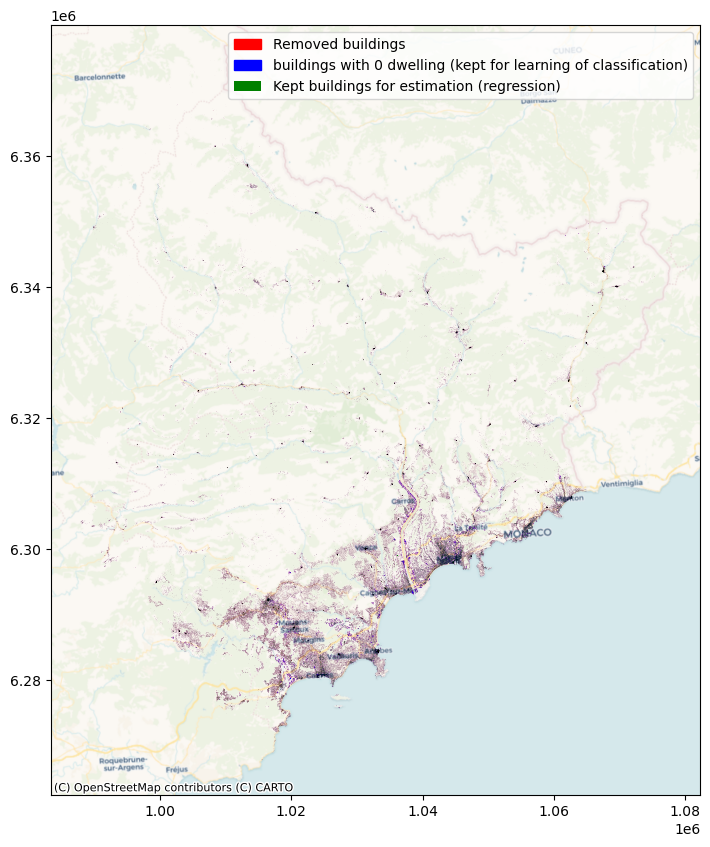

In [7]:
# Appendix A1 : Map of kept / removed buildings
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, color='red', label='Removed buildings'),
    plt.Rectangle((0, 0), 1, 1, color='blue', label='buildings with 0 dwelling (kept for learning of classification)'), 
    plt.Rectangle((0, 0), 1, 1, fc='green', label='Kept buildings for estimation (regression)')
]

ax = building.plot(figsize=(10, 10), color='red')
filtered_building_1.plot(ax=ax, color='blue')
filtered_building_2.plot(ax=ax, color='green')

# Add legend & basemap
ax.legend(handles=legend_handles)
contextily.add_basemap(ax, crs=filtered_building_1.crs, source=contextily.providers.CartoDB.Voyager)

In [ ]:
# Appendix A2 : Interactive map of of kept / large 0 / removed buildings
# Removed and kept buildings - Mapview
from ipyleaflet import Map, GeoData, basemaps, LayersControl, Polygon
import warnings

# Deactivate warnings
warnings.filterwarnings("ignore")

new_crs = "EPSG:4326"  # WGS84
# Convert the GeoDataFrame to the new CRS
administrative = administrative.to_crs(new_crs)

# Get centroids to put the location of the map
latitude = administrative.centroid.iloc[0].y
longitude = administrative.centroid.iloc[0].x

# Create a folium map
map = folium.Map(location=[latitude, longitude], tiles="OpenStreetMap", zoom_start=14.5)

# Create GeoJson layers and add them to the map
folium.GeoJson(building, style_function=lambda x: {'color': 'red'}).add_to(map)
folium.GeoJson(filtered_building_1, style_function=lambda x: {'color': 'blue'}).add_to(map)
folium.GeoJson(filtered_building_2, style_function=lambda x: {'color': 'green'}).add_to(map)

# Display the map
map